In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_size = 3
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 64, activation = tf.nn.relu)
        feed = tf.layers.dense(feed, 32, activation = tf.nn.relu)
        feed = tf.layers.dense(feed, 8, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1
batch_size = 32
agent = Agent(window_size)
epoch = 50

In [6]:
for e in range(epoch):
    state = get_state(close, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    for t in range(0, l, skip):
        action = agent.act(state)
        next_state = get_state(close, t + 1, window_size + 1)
        done = True
        reward = -10

        if action == 1:
            agent.inventory.append(close[t])

        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(close[t] - bought_price, 0)
            done = False
            total_profit += close[t] - bought_price

        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print('epoch %d, total profit %f' % (e + 1, total_profit))

epoch 1, total profit 220.779721
epoch 2, total profit 353.865113
epoch 3, total profit 318.339661
epoch 4, total profit 265.395023
epoch 5, total profit 119.539981
epoch 6, total profit 110.429996
epoch 7, total profit 70.684815
epoch 8, total profit -79.230162
epoch 9, total profit 53.930054
epoch 10, total profit 41.609925
epoch 11, total profit 140.440063
epoch 12, total profit 39.459902
epoch 13, total profit 73.609985
epoch 14, total profit -8.230039
epoch 15, total profit 13.049930
epoch 16, total profit 4.579958
epoch 17, total profit -9.080076
epoch 18, total profit 9.964845
epoch 19, total profit 4.169862
epoch 20, total profit 60.479921
epoch 21, total profit 12.389893
epoch 22, total profit -9.710082
epoch 23, total profit 3.599854
epoch 24, total profit -28.080200
epoch 25, total profit 17.329835
epoch 26, total profit 30.729798
epoch 27, total profit 35.689882
epoch 28, total profit 39.229981
epoch 29, total profit 13.489930
epoch 30, total profit 32.339905
epoch 31, tota

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 21: buy 1 unit at price 750.500000, total balance 9242.929993
day 23: buy 1 unit at price 759.109985, total balance 8483.820008
day 25, sell 1 unit at price 776.419983, investment 3.453695 %, total balance 9260.239991,
day 27, sell 1 unit at price 789.270020, investment 3.973078 %, total balance 10049.510011,
day 37: buy 1 unit at price 791.549988, total balance 9257.960023
day 38, sell 1 unit at price 785.049988, investment -0.821174 %, total balance 10043.010011,
day 97: buy 1 unit at price 814.429993, total balance 9228.580018
day 98: buy 1 unit at price 819.510010, total balance 8409.070008
day 99, sell 1 unit at price 820.919983, investment 0.796875 %, total balance 9229.989991,
day 100, sell 1 unit at price 831.409973, investment 1.452083 %, total balance 10061.399964,
day 112: buy 1 unit at price 837.169983, total balance

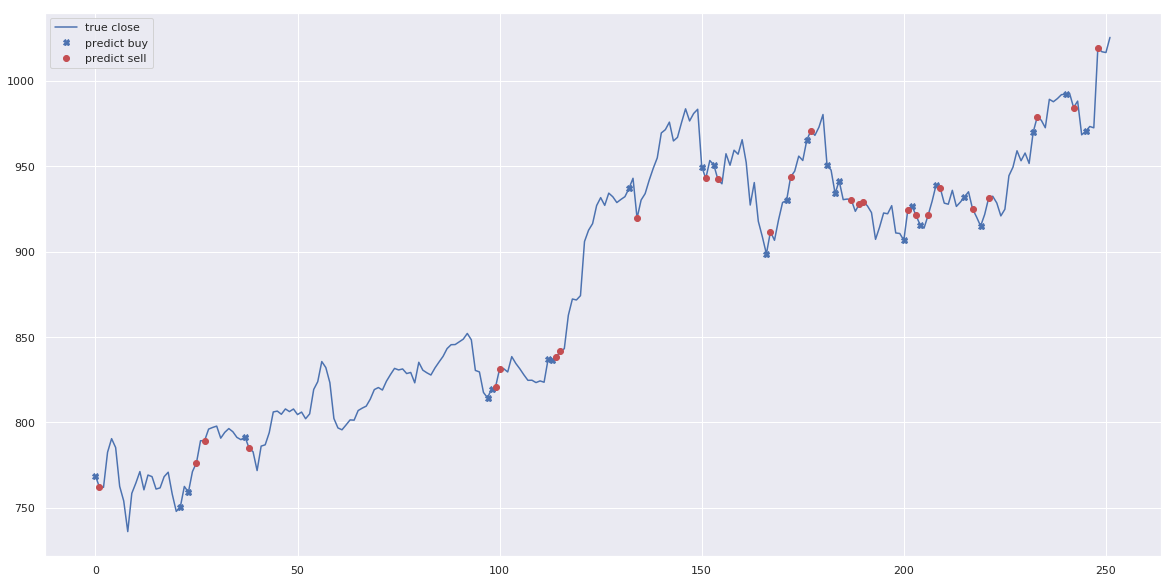

In [7]:
state = get_state(close, 0, window_size + 1)
initial_money = 10000
starting_money = initial_money
states_sell = []
states_buy = []
agent.inventory = []

for t in range(0, l, skip):
    action = agent.act(state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        agent.inventory.append(close[t])
        initial_money -= close[t]
        states_buy.append(t)
        print(
            'day %d: buy 1 unit at price %f, total balance %f'
            % (t, close[t], initial_money)
        )
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        initial_money += close[t]
        states_sell.append(t)
        try:
            invest = ((close[t] - bought_price) / bought_price) * 100
        except:
            invest = 0
        print(
            'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
            % (t, close[t], invest, initial_money)
        )
    state = next_state

invest = ((initial_money - starting_money) / starting_money) * 100
print(
    '\ntotal gained %f, total investment %f %%'
    % (initial_money - starting_money, invest)
)
plt.figure(figsize = (20, 10))
plt.plot(close, label = 'true close')
plt.plot(close, 'X', label = 'predict buy', markevery = states_buy, c = 'b')
plt.plot(close, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
plt.legend()
plt.show()